# 基于lstm的非真实答案选择深度学习模型

谭明，西塞罗多斯桑托斯，向斌和鲍恩.周

IBM沃森核心技术公司，纽约，美国

谭明,cicerons, 周兵霞@us.ibm.com








# 摘要
在本文中，我们应用了一个通用的深度学习框架来完成答案选择任务，它不依赖于手工定义的特征或语言工具。其基本框架是基于双向长短时记忆(biLSTM)模型构建问题和答案的嵌入，并通过余弦相似度度量它们的亲密度。我们从两个方面进一步扩展了这个基本模型。一个方向是将卷积神经网络与基本框架相结合，定义一个更加复合的问答表示。另一个方向是利用简单而有效的注意机制，根据问题上下文生成答案表示。提供了几种不同的模型。模型由两个数据集进行检查，包括TREC-QA和InsuranceQA。实验结果表明，提出的模型明显优于几个强基线。

# 1 介绍
答案选择问题可以被如下定义:给定一个问题q,答案候选池{a1, a2,···}对这个问题,我们的目标是寻找最佳的候选答案ak,k属于1≤k≤s。答案是一个任意长度的词序列,和一个问题可以对应多个真实的答案。在测试中，考生对问题的回答可能不会在训练阶段被观察到。在典型的问答系统中，答案选择是一个重要的组成部分。它也是一个独立的任务，在知识库建设和信息提取方面有应用。

这项任务的主要挑战是，正确的答案可能不会直接与问题共享词汇单元。相反，它们可能只在语义上相关。此外，答案有时是嘈杂的，包含大量不相关的信息。

近年来，深度学习模型在语义分析(Tang et al.， 2015)、机器翻译(Bahdanau et al.， 2015)和文本摘要(Rush et al.， 2015)等各种自然语言处理任务上取得了显著的成功。

在本文中，我们提出了一个不需要任何特征工程、语言工具或外部资源的深度学习框架来进行答案选择。该框架基于对问题和答案分别建立双向长短时记忆(biLSTM)模型，并与池层连接，利用相似性度量度量匹配程度。我们从两个方面改进了这个基本模型。首先，简单的池层可能存在无法保存本地语言信息的问题。为了更好地嵌入问题和答案，我们在biLSTM的基础上构建了卷积神经网络(CNN)结构。其次，为了更好地根据问题区分候选答案，我们将一个简单而有效的注意模型引入到该框架中，根据问题上下文生成嵌入的答案。

我们报告了两个答案选择的数据集的实验结果:(1)InsuranceQA，这是最近发布的一个来自保险领域的大规模非事实性QA数据集。与两个非DL基线和一个基于CNN的强DL基线相比，所提出的模型表现出了显著的性能优势。(2)由Wang等人基于文本检索会议(TREC)QA创建的跟踪数据。所提出的模型优于各种强基线。

论文的其余部分组织如下:第2节阐述了选题的相关工作;第3节提供建议模型的详情;第4节和第5节分别讨论了InsuranceQA和TREC-QA数据集的实验设置和结果;最后，我们在第6节中得出结论

# 2 相关工作

以前关于答案选择的工作通常使用特性工程、语言工具或外部资源。例如，基于WordNet构造语义特征。该模型基于词的语义关系对语义相关词进行配对。答案选择问题转换为问题/答案解析树之间的语法匹配。一些工作尝试使用依赖关系解析树之间的最小编辑序列来实现匹配。近年来，对解析树的判别树编辑特征提取和工程实现实现了自动化。

虽然这些方法显示了有效性，但是它们可能会受到额外资源的可用性、特性工程的努力和引入语言工具(如解析树和依赖树)的系统复杂性的影响。

之前已有使用深度学习技术进行答案选择任务的方法。非事实性问题的回答方法一般从以下几个方面来寻求解决方案:首先，通过一定的相似性度量来学习和匹配问题和答案的表示形式。其次，在问题和答案的基础上构造一个联合特征向量，然后将任务转换为分类或学习排序问题。最后，最近提出的文本生成模型本质上可以用于选择和生成答案。

本文提出的框架属于第一类。我们的方法和之前的工作有两个主要的区别:(1)之前开发的架构仅仅基于CNN，而我们的模型是基于双向LSTMs的，它更能够利用长期序列上下文信息。此外，为了获得更好的性能，我们还在biLSTM的顶部集成了CNN结构。(2) Feng等人独立处理问题和答案，而提出的结构开发了一个有效的注意力模型，根据问题生成答案嵌入。












# 3 方法

在本节中，我们将描述所提议的框架及其变化。本文首先介绍了一个总体框架，即在问题及其候选答案的基础上建立双向LSTM，然后利用相似性度量度量问题答案对之间的距离。在下面的两个小节中，我们将从两个独立的方向扩展基本模型。

## 3.1基本模型:QA-LSTM
长短时记忆(LSTM):递归神经网络(RNN)被广泛应用于处理变长序列输入。远程历史存储在一个递归的隐藏向量中，该隐藏向量依赖于前一个隐藏向量。LSTM是RNN的一种常用变种方法，用于解决RNN的梯度消失问题。我们的LSTM实现与稍加修改的实现类似。给定一个输入序列x = x(1)， x(2)， x(n)，其中x(t)是一个e维向量。第t步时的隐藏向量h(t)(大小为h)更新如下:
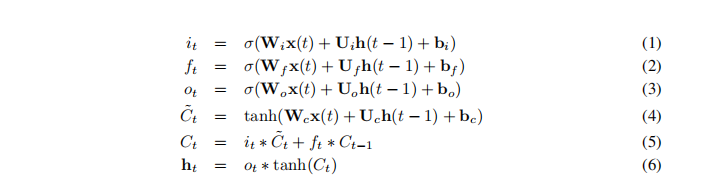

在LSTM架构中,有三个门(输入i,忘记f和输出o),和一个记忆向量c .σ是sigmoid函数。输入门可以确定传入向量xt如何改变存储单元的状态。输出门可以允许记忆单元对输出产生影响。最后，遗忘门允许单元记住或忘记它以前的状态。W∈RH×E, U∈RH×H, b∈RH×1为网络参数。

双向长短时记忆(biLSTM):单向lstm的缺点是不能利用未来词的上下文信息。双向LSTM通过在两个方向上处理序列，利用之前的上下文和未来的上下文，生成两个独立的LSTM输出向量序列。一个按正向处理输入序列，而另一个按反向处理输入序列。每个时间步长的输出是两个方向上的输出向量的串联，即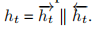。

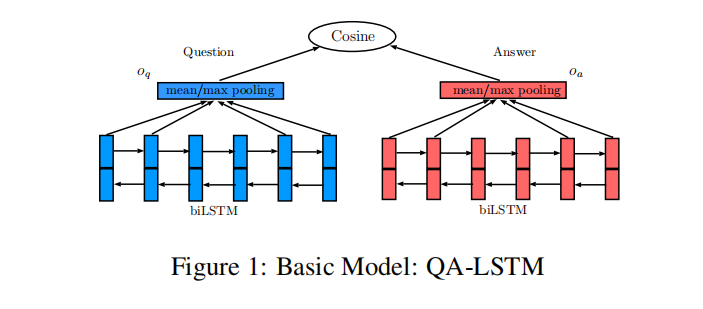
QA-LSTM:该工作中的基本模型如图1所示。BiLSTM分别为问题和答案生成分布式表示，然后利用余弦相似性度量它们之间的距离。在相同的排名损失之后，我们将训练目标定义hinge损失。
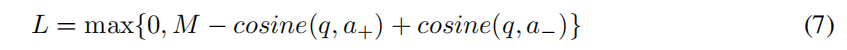

其中a+为地面真值答案，a为从整个答案空间随机抽取的不正确答案，M为常数边距。我们将具有多个基本真理的任何问题视为多个训练示例，每个示例对应一个基本真理。

基于单词级biLSTM输出，有三种简单的方法来生成问题和答案的表示形式:(1)平均池;(2)最大池;(3)两个方向上最后一个向量的拼接。并与第五章的实验结果进行了比较。在余弦相似度匹配之前，对QA表示进行Dropout操作。

最后，通过初步实验，我们发现，问答双方共享相同网络参数的体系结构明显优于问答双方各自拥有参数的体系结构，且收敛速度更快。如前所述，这是合理的，因为对于共享层网络，问答向量中的对应元素表示相同的biLSTM输出。而对于具有独立的问答参数的网络，则不存在这样的约束，模型的参数是两倍大，这使得优化器很难学习。
## 3.2 QA-LSTM / CNN
在前一小节中，我们仅通过简单的操作(如max或mean pooling)生成问答表示。在本节中，我们使用了一个基于biLSTM输出的CNN结构，以便给出一个更综合的问题和答案的表示。
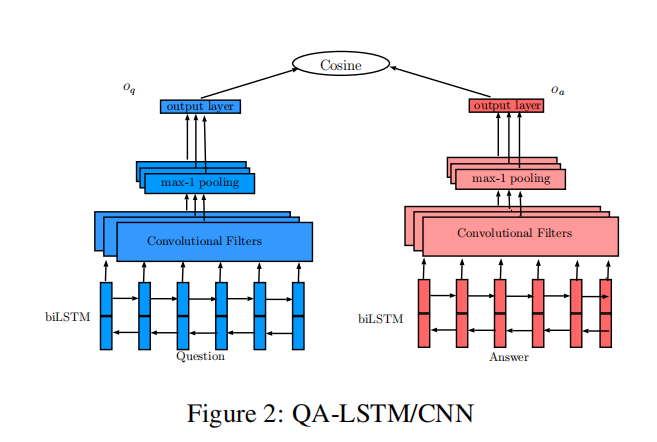
本文中CNN的结构类似于(Feng et al.， 2015)，如图2所示。与传统的前向神经网络不同，卷积结构只在滤波器大小为m的输入之间施加局部交互作用。

在本工作中，对于biLSTM中每一个大小为m的窗口输出向量，即Hm(t) =[h(t)，h(t+1)，···，h(t+m-1)]，其中t为一定的时间步长，卷积滤波器F = [F(0)···F(m m 1)]将生成一个值，如下所示。
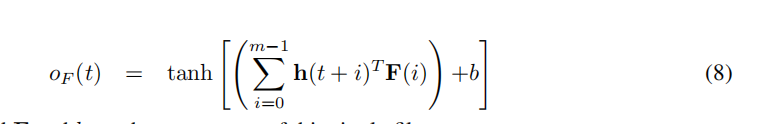

其中b为偏置，F和b为单滤波器的参数。

与典型的CNNs一样，max-k池层构建在卷积层的顶部。总体上，我们要强调每个卷积滤波器的top-k值。通过k-maxpooling，将为一个过滤器保留最大k值，这表示一个过滤器与输入序列匹配的最高程度。

最后，有N个不同初始化参数的并行滤波器，卷积层得到N维输出向量。我们得到了两个输出向量与尺寸为kN分别为问题和答案。在这项工作中，k = 1。在我们早期的实验中，k> 1没有表现出任何明显的改善。这种结构的直观之处在于，我们并没有像前一小节那样平均考虑每个词的词汇信息，而是强调了答案的某些部分，这样QA-LSTM/CNN可以更有效地区分基本事实和错误答案。

## 3.3ATTENTION-QA-LSTM
在上一小节中，我们描述了基本模型的一个扩展，它的目标是分别为问题和答案提供更多的复合嵌入。在本小节中，我们将从另一个角度研究扩展。我们没有单独生成QA表示，而是利用一个简单的注意力模型来生成基于问题的答案向量。

当双向LSTM模型必须在问题和答案上长距离传播依赖关系时，隐藏向量的固定宽度成为瓶颈。注意力机制被用来通过动态对齐问题答案中信息量更大的部分来缓解这一弱点。这一策略已被用于许多其他自然语言处理任务，如机器翻译、句子摘要和事实问题的回答。

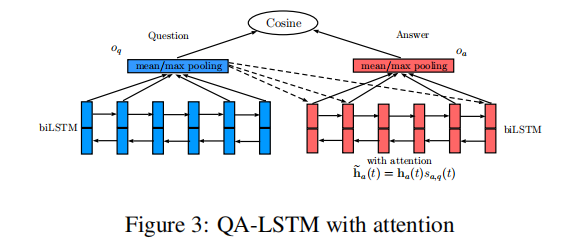

受(Hermann et al.， 2015)的工作启发，我们在基本模型上开发了一个非常简单但有效的单词级注意力。图3显示了该结构。在平均池或平均池之前，每个biLSTM输出向量将乘以一个softmax权值，该权值由biLSTM的问题嵌入决定。

具体来说,给定的输出向量biLSTM答案在时间步t,和问题嵌入,oq,更新后的向量ha(t)每个答案词(t)制定如下。
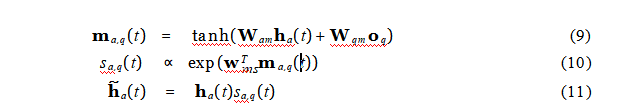

其中Wam、Wqm和wms是注意参数。从概念上讲，注意力机制对某些单词给予了更多的权重，就像tf-idf对每个单词一样。然而，前者根据问题信息计算权重。

这种方法与(Hermann et al.， 2015)中的方法的主要区别在于，Hermann et al.(2015)的细心读者强调支持事实的信息部分，然后使用查询和支持事实的组合嵌入来预测事实答案。在这项工作中，我们直接使用基于注意力的表示来度量问题/答案之间的距离。实验表明，该注意机制能够根据问题文本更有效地区分正确答案和错误答案。

## 3.4 QA-LSTM / CNN与ATTENTION
前面介绍的两个扩展以一种简单的方式组合在一起。首先，将答案ha(t)的biLSTM隐藏向量乘以sa,q(t)，由问题平均值计算得到汇聚向量oq，并更新为ha(t)，如式9-11所示。然后，原始的问题和更新后的答案隐藏向量分别作为CNN结构的输入，这样问题上下文就可以用来评估CNN输入的软最大权值。通过实验，我们发现这两个扩展对性能改进的贡献因数据集的不同而有所不同。然而，用Attention的QA-LSTM/CNN可以在这两个数据集上超越基线。



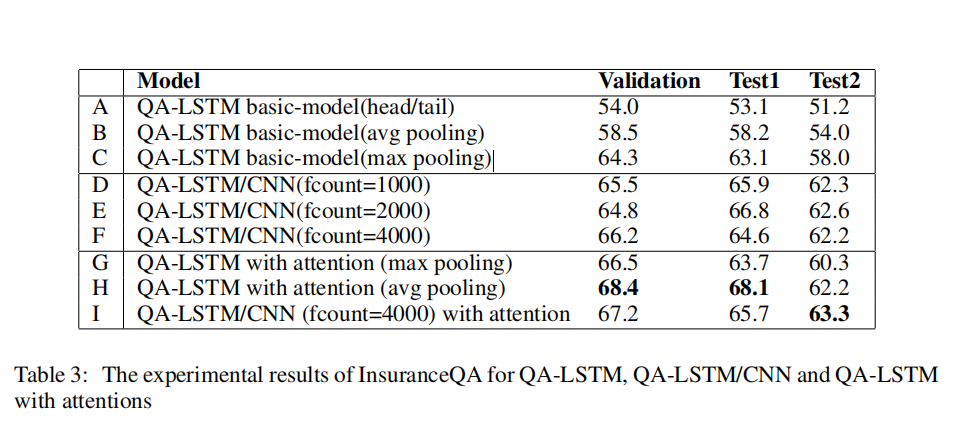